In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import os

In [2]:
FINE_TUNING_EPOCHS = 5
TRAINING_EPOCHS = 3
BATCH_SIZE = 32
image_height = 224
image_width = 224

In [3]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale = 1./255,
                         zoom_range = 0.05,
                         width_shift_range = 0.05,
                         height_shift_range = 0.05,
                         brightness_range = [0.95,1.05])
train_generator = gen.flow_from_directory(
    directory = "C:/Users/Windows/Downloads/chest_xray/train", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)



test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_directory(
    directory   = "C:/Users/Windows/Downloads/chest_xray/val", # images data path / folder in which images are there
    color_mode  ="rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_directory(
    directory   = "C:/Users/Windows/Downloads/chest_xray/test", # images data path / folder in which images are ther
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# Get labels in dataset
a = train_generator.class_indices
a
class_names = list(a.keys())  # storing class/breed names in a list
class_names # ['NORMAL', 'PNEUMONIA']

train_generator.classes

array([0, 0, 0, ..., 1, 1, 1])

([<matplotlib.patches.Wedge at 0x29baf2a6388>,
 [Text(0.760292067193507, 0.7949565853319438, 'NORMAL'),
  Text(-0.7602920671935072, -0.7949565853319437, 'PNEUMONIA')],
 [Text(0.41470476392373107, 0.43361268290833294, '25.7%'),
  Text(-0.4147047639237311, -0.4336126829083329, '74.3%')])

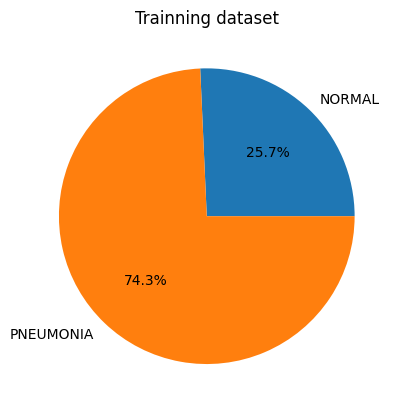

In [5]:
#pie plot of dataseat
freq = np.unique(train_generator.classes, return_counts=True)
plt.title("Trainning dataset")
plt.pie(freq[1], labels = class_names, autopct='%1.1f%%')

In [6]:

# clearly an umbalanced data set so let's some class weights
#顯然是一個不平衡的數據集，所以讓我們來一些類別權重
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

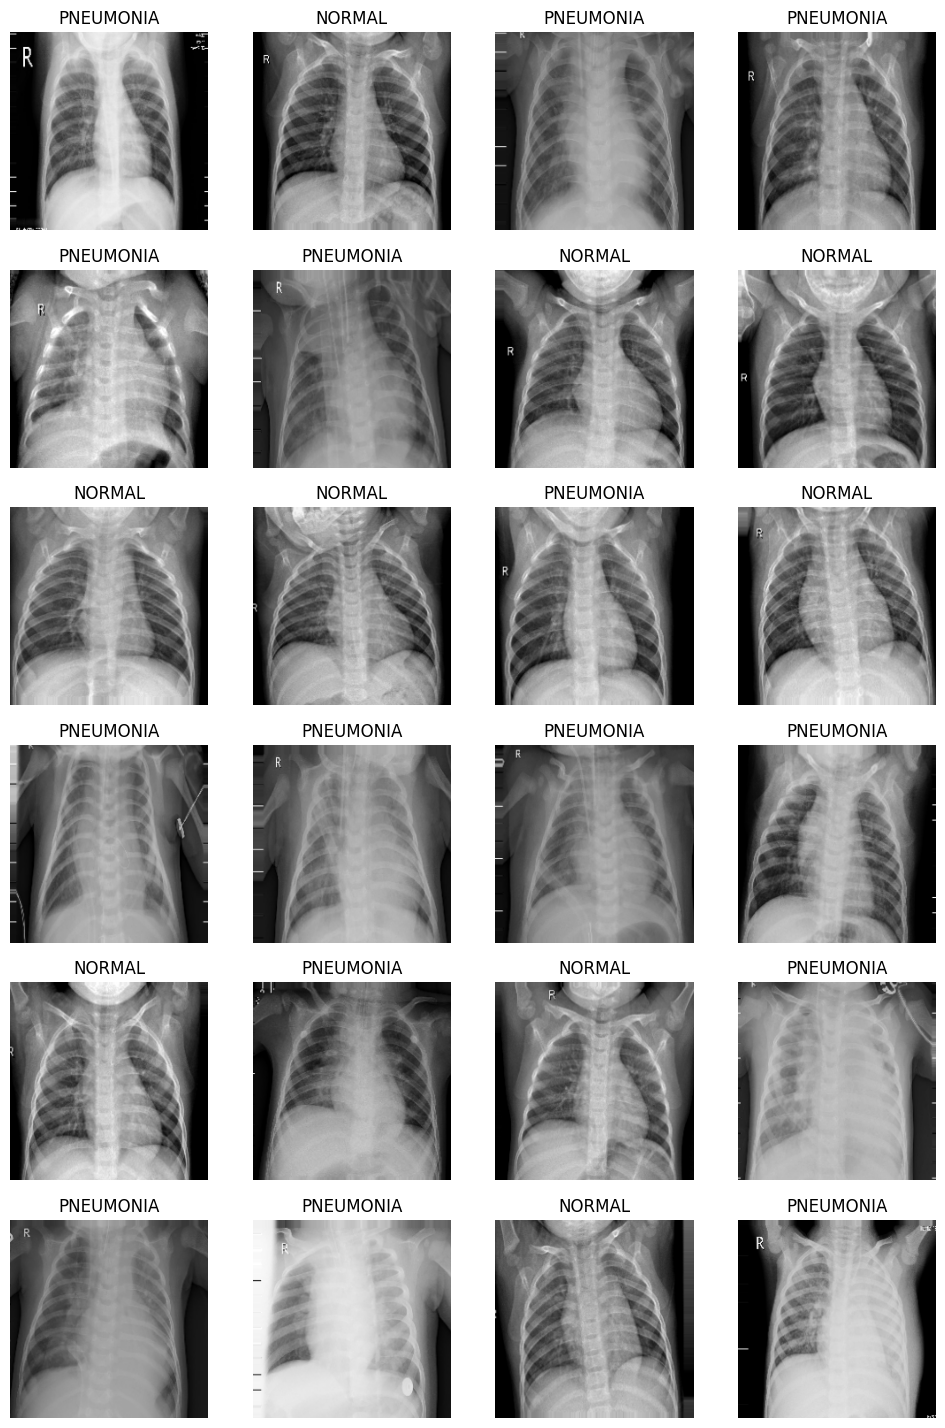

In [7]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])    

x,y = next(train_generator)
plot_images(x,y)

In [8]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    new_title = f'{title}\n Sensitivity = {sensitivity:.2f} Specificity = {specificity:.2f}'
    
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    
    ax.set_title(new_title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [10]:
from tensorflow.keras.models import Model
def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model 

In [11]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    '''
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back
    '''
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        #callbacks = [early],
                        class_weight=class_weights)
    
    return history

In [12]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

vgg16_model = create_model(vgg16_base_model)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
history = fit_model(vgg16_model, vgg16_base_model, epochs = 3)

Unfreezing number of layers in base model =  0
Epoch 1/3
163/163 [==============================] - 802s 5s/step - loss: 0.4035 - accuracy: 0.8248 - val_loss: 0.4810 - val_accuracy: 0.7500
Epoch 2/3
163/163 [==============================] - 1019s 6s/step - loss: 0.2315 - accuracy: 0.9068 - val_loss: 0.3096 - val_accuracy: 0.8125
Epoch 3/3
163/163 [==============================] - 264s 2s/step - loss: 0.2000 - accuracy: 0.9201 - val_loss: 0.6664 - val_accuracy: 0.7500


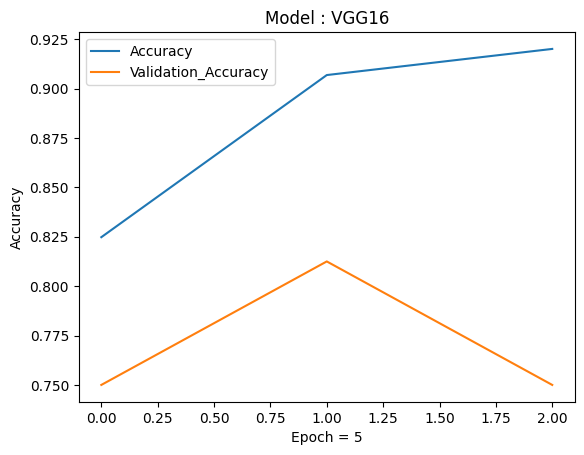

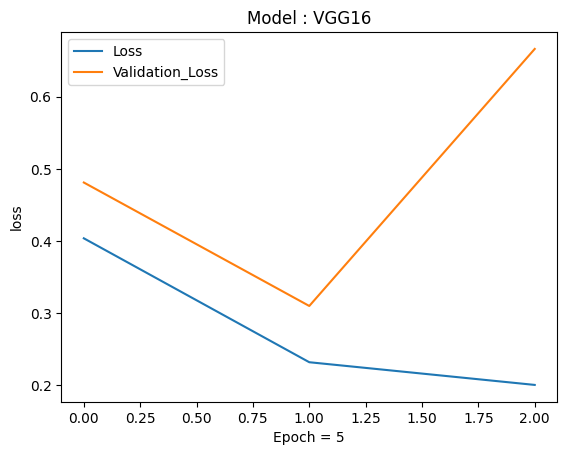

In [14]:
import matplotlib.pyplot as plt
#plot model accuracy_plot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch = 5")
plt.legend(["Accuracy","Validation_Accuracy"])
plt.title("Model : VGG16")
plt.show()

#plot model loss_plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("Epoch = 5")
plt.legend(["Loss","Validation_Loss"])
plt.title("Model : VGG16")
plt.show()


20/20 [==============================] - 19s 952ms/step - loss: 0.3138 - accuracy: 0.8830
[0.3138483166694641, 0.8830128312110901]
Accuracy: 88.30%
Loss: 0.314
20/20 [==============================] - 20s 959ms/step


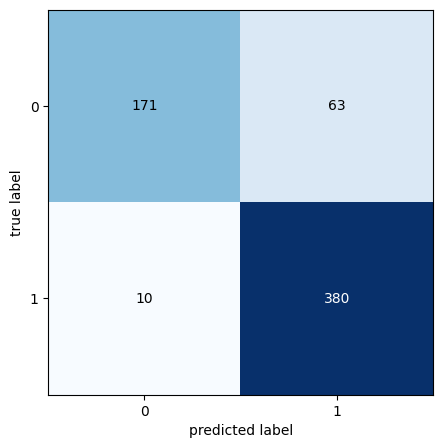

In [15]:
accuracy_score = vgg16_model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))


true_classes = test_generator.classes
vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)


from sklearn.metrics import confusion_matrix
CM = confusion_matrix(true_classes, vgg16_test_pred_classes)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = CM, figsize = (5, 5))
plt.show()
